In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import numpy as np
plt.style.use('dark_background')
import data
from sklearn.model_selection import KFold
from style import *
import itertools
from sklearn import mixture
from matplotlib_venn import venn3, venn2
import viz
import config
outcome_def = 'y_consec_thresh'

In [8]:
df = data.get_data()
df = df[df['valid'] == 1] # exclude test cells, short/long tracks, hotspots
viz.print_metadata()

def sort_outcome(df, outcome_def):
    outcome_score = df['Y_max'].values
    idxs_sort = np.argsort(outcome_score)
    return df[outcome_def].values[idxs_sort], df['Y'].values[idxs_sort]

outcome_sort, Y_sort = sort_outcome(df, outcome_def)

valid:		2066 aux+ / 7594 (0.272)
----------------------------------------
hotspots:	 349 aux+ /  349
short:		 212 aux+ / 4266 (0.950)
long:		  41 aux+ /   43 (0.953)
hard:		1482 aux+ / 2936 (0.505)


# unsure tracks

In [67]:
df = data.get_data(use_processed=False, use_processed_dicts=True, 
                           outcome_def=outcome_def, remove_hotspots=False)

loading + preprocessing data...
	loading tracks...
	preprocessing data...
	adding features...


In [ ]:
labels_cs = {
    'pos': [2321, 11032, 4484, 4750, 8084, 6770, 6624, 2749, 6378, 7833, 4399, 9547, 2253],
    'hotspots': [10069, 5485, 3146, 5560, 5600, 5937, 7688, 6055, 5670, 10235, 5583, 6151, 5720, 2553, 6040, 292, 5456, 2437, 5966, 5499, 10043, 10232, 5434, 6224, 5785, 6210, 2761, 6359, 6438, 5423, 5774, 7556, 5766, 7882, 7732, 5798, 2711, 2562, 5939, 2214, 2881, 2588, 10123, 6527, 10309, 2038, 2683, 5617, 2146, 4117, 10821, 2538, 5408, 5527, 6079, 7499, 6641, 2930, 5683, 6353, 5958, 2154, 5835],  # note first were labeled as neg, second were labeled as pos
    'neg': [3964, 10054, 735, 846, 1362, 3823, 5389, 8834, 9565, 10882, 11166, 718]
}
labels_xl = {
    'pos': [2321, 10996, 4454, 10431, 11032, 10057, 4484, 8084, 10754, 2382, 938, 2228, 10887, 6770, 10895, 10863, 6624, 10333, 4069, 10113, 4849, 9719, 10116, 245, 10077, 9547, 9557, 10457, 10037, 9900, 10146, 5507, 10517, 2749, 9563, 6378, 2014, 9714, 1353, 10117, 7504, 9724, 3141, 5797, 10508, 10374, 5593, 9932, 4399, 10632, 1039, 9904, 9930, 8505, 429, 10331, 5470, 8557, 7773, 10830, 10749, 2031, 3822, 7833, 5791, 10602, 2203, 542, 10843, 7759, 10483, 4827, 225, 7679, 9617, 2378, 5409, 10142, 9975, 10264, 918, 10148, 10066, 9917, 9485, 6400, 5961, 10023, 10418, 231, 10695, 3065, 6420, 7865, 9813, 10765, 6290, 2270, 729, 2626, 8424, 10199, 2200, 2854, 2253],
    'hotspots': [10015, 6339, 3168, 7481, 7779, 646, 4117, 7891, 4324, 2146, 10007, 1162, 10330, 285, 5527, 7616, 5617, 4196, 7771, 2085, 1104, 5512, 8303, 4409, 7343, 2538, 7570, 3977, 2683, 2038, 10250, 2494, 10309, 8423, 2417, 6353, 2564, 685, 6471, 6527, 10123, 2173, 2588, 205, 2881, 5863, 5958, 5408, 2607, 2214, 5939, 2562, 6079, 8208, 2154, 2799, 3909, 5798, 7663, 2574, 7732, 5835, 7882, 5766, 7556, 6438, 6641, 6359, 2761, 6210, 5434, 10232, 10043, 6109, 2323, 9550, 2437, 5456, 2930, 5683, 413, 2553, 7499, 6151, 5583, 10235, 6055, 7688, 5600, 5560, 3146, 5485, 10069, 5423, 5499, 6224, 5937, 292],
    'neg': [718, 735, 846, 1362, 3823, 5389, 8834, 9565, 10882, 11166, 10054]
}
    
pos_all = set(labels_cs['pos']).union(set(labels_xl['pos']))
pos_int = set(labels_cs['pos']).intersection(set(labels_xl['pos']))
pos = pos_all - pos_int

hots_all = set(labels_cs['hotspots']).union(set(labels_xl['hotspots']))
hots_int = set(labels_cs['hotspots']).intersection(set(labels_xl['hotspots']))
hots = hots_all - hots_int

neg_all = set(labels_cs['neg']).union(set(labels_xl['neg']))
neg_int = set(labels_cs['neg']).intersection(set(labels_xl['neg']))
neg = neg_all - neg_int
print(len(pos), len(hots), len(neg))
print(neg)

for k, inds in zip(['pos', 'hots', 'neg'], [pos, hots, neg]):
    d = df[df.pid.isin(inds)]
    print(k, d.shape)
    R, C = 11, 10
    plt.figure(figsize=(20, 24)) #, dpi=200)
    lifetime_max = np.max(df.lifetime.values[:R*C])
    print(lifetime_max)
    for i in range(R * C):
        if i < d.shape[0]:
            plt.subplot(R, C, i + 1)
            row = d.iloc[i]
            plt.plot(row.X, color='red', label='clathrin')
            plt.plot(row.Y, color='green', label='auxilin')
            plt.axhline(642.3754691658837, color='gray', alpha=0.5)
            plt.xlim([-1, lifetime_max + 1])
            plt.title(row.pid)
    #         plt.ylim([-10, max(max(df.X_max), max(df.Y_max)) + 1])
            plt.axis('off')
    plt.savefig(k + '.pdf')
    plt.legend()
    plt.tight_layout()
#     plt.show()

# visualize outcomes
- take mean, take sigma, define events with a threshold

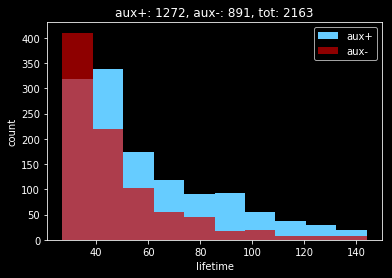

In [6]:
outcome = df[outcome_def]
aux_pos = df['lifetime'][outcome==1] 
aux_neg = df['lifetime'][outcome==0] 
plt.hist(aux_pos, label='aux+', alpha=1, color=cb)
plt.hist(aux_neg, label='aux-', alpha=0.7, color=cr)
plt.xlabel('lifetime')
plt.ylabel('count')
plt.title(f'aux+: {aux_pos.shape[0]}, aux-: {aux_neg.shape[0]}, tot: {df.shape[0]}')
plt.legend()
plt.show()

# viz curves

In [ ]:
viz.plot_curves(df[df.pid.isin(data.get_labels()['hotspots'])])

In [ ]:
R, C = 4, 5
# plt.figure(dpi=200)
plt.figure(figsize=(9, 8), dpi=200)
n = Y_sort.shape[0]
# idxs = list(range(10)) + list(range(n - 10, n)) # let's look at the top / bot
idxs = list(range(num_neg - 40, num_neg + 40)) # let's look at ones in the middle
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    idx = idxs[i]
    plt.plot(Y_sort[idx], color=cr if outcome_sort[idx] == 0 else cb)
#     plt.axis('off')
plt.tight_layout()

**compare as a func of aux_max**

In [ ]:
R, C = 20, 28
# plt.figure(dpi=200)
plt.figure(figsize=(28, 20))
n = Y_sort.shape[0] # 1434

idxs = np.array([np.arange(int(i), int(i) + C) for i in np.linspace(0, n - C, R)]).flatten() #list(range(10)) + list(range(n - 10, n))
Ys = Y_sort[idxs]
ymin = -200
ymax = 4000

for i in range(R * C):
    plt.subplot(R, C, i + 1)
    idx = idxs[i]
    plt.plot(Ys[i], color=cr if outcome_sort[idx] == 0 else cb, lw=1)
    plt.ylim((ymin - 1, ymax + 1))
    plt.xlim((0, 120))
    if not i == R * C - C:
        plt.yticks([])
        plt.xticks([])
    if i % C == 0:
        plt.ylabel(f'{np.max(Ys[i]):.0f}')
#     plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig('figs/aux_max.pdf')

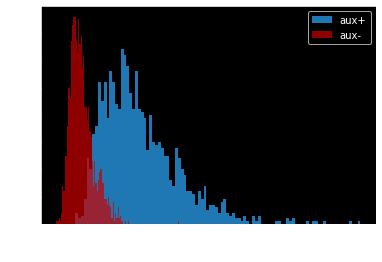

In [10]:
aux_plus = df[outcome_def] == 1
plt.hist(df[aux_plus]['Y_max'], color=cb, label='aux+', bins=100)
plt.hist(df[~aux_plus]['Y_max'], color=cr, label='aux-', alpha=0.7, bins=100)
plt.xlabel('aux_max')
plt.ylabel('count')
plt.legend()
plt.show()

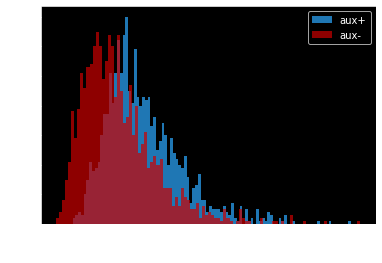

In [12]:
aux_plus = df[outcome_def] == 1
plt.hist(df[aux_plus]['X_max'], color=cb, label='aux+', bins=100)
plt.hist(df[~aux_plus]['X_max'], color=cr, label='aux-', alpha=0.7, bins=100)
plt.xlabel('clath_max')
plt.ylabel('count')
plt.legend()
plt.show()

In [18]:
accs_cum_lower = np.array([1 - np.mean(df[outcome_def][df['X_max'] <= l])
                           for l in sorted(df['X_max'])])

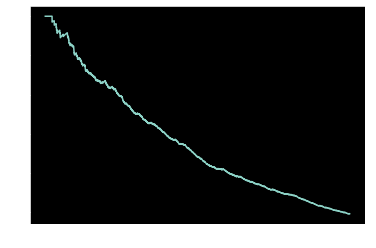

In [19]:
plt.plot(accs_cum_lower)

# look at hotspots

In [16]:
dfh = data.get_data(use_processed=True, remove_hotspots=False,
                         processed_file='processed/df_with_hotspots.pkl', metadata_file='processed/metadata_with_hotspots.pkl',)

loading + preprocessing data...
	loading tracks...
	preprocessing data...
	adding features...
dict features not added!


In [ ]:
dh = dfh[df.hotspots==1]
R = int(np.sqrt(dh.shape[0]))
C = (dh.shape[0] // R) + 1
plt.figure(figsize=(C, R), dpi=200)

for i in range(R * C):
    if i < dh.shape[0]:
        ax = plt.subplot(R, C, i + 1)
        row = dh.iloc[i]
        plt.axis('off')
        Y = np.array(row['Y'])
        ts = np.arange(Y.size)
        plt.plot(ts, np.array(row['X']), color=cr, lw=1)
        plt.plot(ts, Y, color='green', lw=1)
        plt.plot(ts[row['sig_idxs']==True], Y[row['sig_idxs']], 'o', color='white', ms=1, alpha=0.5)

    #     plt.plot(dh.iloc[i]['X'], color='red')
        ax.text(.5, .9, f'{i}',
                         horizontalalignment='right',
                         transform=ax.transAxes)


        plt.ylim((-1000, 4000))
        plt.xlim((0, 120))

# plt.suptitle(f'clath divided by 2 to fit on same scale xscale is 120')
plt.tight_layout()
plt.savefig('hotspots.pdf')
plt.show()

# compare different outcome defs

In [ ]:
keys = ['y_thresh', 'y_single_sig', 'y_double_sig', 'y_consec_sig', 'y']
mat = df[keys] #.corr()# make fig
# plt.figure(dpi=200)
# sns.heatmap(mat.corr(method='spearman'), annot=True,
#             cmap=sns.diverging_palette(10, 240, as_cmap=True, center='light'), vmin=-1, vmax=1)
# plt.show()

plt.figure(dpi=200)
sns.barplot(x=keys, y=mat.sum(), color=cb, alpha=1)
plt.ylabel('num aux+')
plt.xlabel('aux+ definition')

In [ ]:
plt.figure(dpi=200)
idxs = np.arange(df.shape[0])
keys = ['y_thresh', 'y_single_sig', 'y_consec_sig']
venn3([set(idxs[df[keys[0]] == 1]), set(idxs[df[keys[1]] == 1]), set(idxs[df[keys[2]] == 1])], keys)
plt.show()

# analyze aux+ p-value / amplitude defs

In [4]:
aux = df.Y
aux_p = df.Y_pvals

ys = np.array(list(itertools.chain.from_iterable(aux)))
ps = np.array(list(itertools.chain.from_iterable(aux_p.values)))

ps_sig = ps < 0.05

In [ ]:
R = 1
C = 2
plt.figure(figsize=(8, 4), dpi=200)
plt.subplot(R, C, 1)
plt.hist(ps, bins=100, color=cb) #ps[(ps < 0.5) * (ps > 0.01)])
plt.yscale('log')
plt.axvline(0.05, color=cr)
plt.xlabel('auxilin p-value')
plt.ylabel('count (log-scale)')
# plt.xscale('log')
# plt.ylabel()
# plt.xlim((0, 0.1))
print(f'num sig {np.sum(ps_sig):,d}')
print(f'num nonsig {np.sum(~ps_sig):,d}')

plt.subplot(R, C, 2)
ys_sig = ys[ps_sig]
(counts, bins, _) = plt.hist(ys_sig, bins=180, color=cb) #ps[(ps < 0.5) * (ps > 0.01)])
idx_max = np.argmax(counts)
aux_max = bins[idx_max]
plt.axvline(aux_max, color=cr)
plt.xlabel('auxilin amplitude')
plt.ylabel('count')
plt.tight_layout()
plt.show()

print('aux_max', aux_max)

In [ ]:
ys_sig = ys_sig.reshape(-1, 1)
mog = mixture.GaussianMixture(n_components=3)
mog.fit(ys_sig.reshape(-1, 1))
preds = mog.predict(ys_sig.reshape(-1, 1))

# plot hist
plt.figure(dpi=200)
plt.hist(ys_sig, bins=bins, alpha=1, color=cb) #ps[(ps < 0.5) * (ps > 0.01)])
samples, comps = mog.sample(n_samples=ys_sig.size) 
for i in [0, 2, 1]:
    idxs = comps==i
    plt.hist(samples[idxs], bins=bins, alpha=0.75, label=f'{mog.means_[i, 0]}')
plt.axvline(aux_max, color='white')
# plt.legend()

plt.xlabel('auxilin amplitude (significant only)')
plt.ylabel('count')
plt.show()

# rest of nb is finding rules to define outcome

In [5]:
verified_pids = data.get_labels()

In [6]:
def cummax(arr):
    res = [arr[0]]
    for i in range(1, len(arr)):
        res.append(max(arr[i], res[i-1]))
    return res
    
def max_fall(arr):
    cm = cummax(arr)
    return np.max(np.array(cm) - np.array(arr))
    
def max_diff(arr):
    return np.max(-np.diff(arr)) 

def max_absolute_fall(arr):
    cm_rev = cummax(arr[::-1])[::-1]
    return max(arr[i] - cm_rev[i+1] for i in range(len(arr)-1))

In [108]:
# peak time
df['Y_peak_time_frac'] = df['Y_peak_idx'].values / df['lifetime'].values
df['peak_time_frac_diff'] = df['Y_peak_time_frac']  - df['X_peak_time_frac'] 

In [473]:
# local
X_max_around_Y_peak = []
X_max_before_Y_peak = []
X_max_after_Y_peak = []
X_max_fall_around_Y_peak = []  # max fall def: in a window around aux peak, max_{t_1>t_2} Cla(t_1) - Cla(t_2)
X_max_diff_around_Y_peak = []  # max_{t in window} Cla(t) - Cla(t-1)
X_max_abs_fall_around_Y_peak = []

for i in range(len(df)):
    pt = df['Y_peak_idx'].values[i]
    lt = df['lifetime'].values[i]
    left_bf = np.int(0.2 * lt)
    right_bf = np.int(0.2 * lt)
    arr_before = df['X'].iloc[i][: max(1, pt - left_bf)]
    arr_around = df['X'].iloc[i][max(0, pt - left_bf): min(pt + right_bf, lt)]
    arr_after = df['X'].iloc[i][min(pt + right_bf, lt - 1): ]
    X_max_fall_around_Y_peak.append(max_fall(arr_around))
    X_max_diff_around_Y_peak.append(max_diff(arr_around))
    X_max_before_Y_peak.append(min(arr_before))
    X_max_around_Y_peak.append(max(arr_around))
    X_max_after_Y_peak.append(max(arr_after))
    X_max_abs_fall_around_Y_peak.append(max_absolute_fall(arr_around))
    
df['X_max_fall_around_Y_peak'] = X_max_fall_around_Y_peak
df['X_max_abs_fall_around_Y_peak'] = X_max_abs_fall_around_Y_peak
df['X_max_diff_around_Y_peak'] = X_max_diff_around_Y_peak
df['X_max_around_Y_peak'] = X_max_around_Y_peak
df['X_max_before_Y_peak'] = X_max_before_Y_peak
df['X_max_after_Y_peak'] = X_max_after_Y_peak
df['X_max_diff_around_before'] = df['X_max_around_Y_peak'] - df['X_max_before_Y_peak']
df['X_max_diff_around_after'] = df['X_max_around_Y_peak'] - df['X_max_after_Y_peak']
df['y_z_score'] = (df['Y_max'].values - df['Y_mean'].values)/df['Y_std'].values

In [577]:
def ols_coef(x, y):
    cov_mat = np.cov(x, y)
    coef = cov_mat[0, 1]/cov_mat[0, 0]
    corr = cov_mat[0, 1]/np.sqrt(cov_mat[0, 0] * cov_mat[1, 1])
    return coef, corr

X_lr_coef_after_Y_peak = []
X_lr_coef_before_Y_peak = []
for i in range(len(df)):
    pt = df['X_peak_idx'].values[i]
    lt = df['lifetime'].values[i]
    if lt - pt>1 and pt >= 1:
        arr_after = df['X'].iloc[i][pt: min(pt+11, lt)]
        coef, corr = ols_coef(np.array(range(pt, min(pt+11, lt))), arr_after)
        coef_before, _ = ols_coef(np.array(range(max(pt-11, 0), pt + 1)), arr_before)
        X_lr_coef_after_Y_peak.append(corr)
        X_lr_coef_before_Y_peak.append(coef_before)
    else:
        X_lr_coef_after_Y_peak.append(0)
        X_lr_coef_before_Y_peak.append(0)
df['X_lr_coef_after_Y_peak'] = X_lr_coef_after_Y_peak
df['X_lr_coef_before_Y_peak'] = X_lr_coef_before_Y_peak

In [169]:
Y_feat_names = ['X_max',
                'y_consec_sig', 
                'y_conservative_thresh', 
                'Y_peak_time_frac',
                'Y_max',
                'y_z_score',
                #'y_score',
                #'y_thresh',
                #'peak_time_frac_diff',
                #'y_num_sig',
                #'X_max_fall_around_Y_peak',
                #'X_lr_coef_after_Y_peak',
                #'X_lr_coef_before_Y_peak',
                #'X_max_diff_around_Y_peak',
                #'X_max_abs_fall_around_Y_peak',
                'X_max_diff', 
                #'X_max_diff_around_before'
                ]

In [39]:
import math
def rule_based_label(t):
    if t['Y_peak_time_frac'] < 0.2:
        return 0
    if t['y_consec_sig'] or t['y_conservative_thresh']:
        return 1
    if t['X_max_diff'] > 260 and t['y_z_score'] > 2.6:
        return 1
    return 0

#p_label = np.array([rule_based_label(df_label_verified.iloc[i]) for i in range(len(df_label_verified))])

#np.mean(p_label == df_label_verified[outcome_def].values)



In [96]:
import math
def rule_based_model(track):
    if track['y_consec_sig'] or track['y_conservative_thresh']:
        return 1
    if track['X_max_diff'] > 350 and track['Y_max'] > 560:
        return 1
    return 0


def get_rule_based_label(df):
    
    df['Y_peak_time_frac'] = df['Y_peak_idx'].values / df['lifetime'].values
    df['y_z_score'] = (df['Y_max'].values - df['Y_mean'].values)/df['Y_std'].values
    X_max_around_Y_peak = []
    X_max_after_Y_peak = []
    X_max_fall_around_Y_peak = []
    for i in range(len(df)):
        pt = df['Y_peak_idx'].values[i]
        lt = df['lifetime'].values[i]
        left_bf = np.int(0.2 * lt)
        right_bf = np.int(0.1 * lt)
        arr_around = df['X'].iloc[i][max(0, pt - left_bf): min(pt + right_bf, lt)]
        arr_after = df['X'].iloc[i][min(pt + right_bf, lt - 1): ]
        #X_max_fall_around_Y_peak.append(max_fall(arr_around))
        X_max_around_Y_peak.append(max(arr_around))
        X_max_after_Y_peak.append(max(arr_after))
    #df['X_max_fall_around_Y_peak'] = X_max_fall_around_Y_peak
    df['X_max_around_Y_peak'] = X_max_around_Y_peak
    df['X_max_after_Y_peak'] = X_max_after_Y_peak
    df['X_max_diff'] = df['X_max_around_Y_peak'] - df['X_max_after_Y_peak']
    
    df['y_rule_based'] = np.array([rule_based_model(df.iloc[i]) for i in range(len(df))])
    return df
    

In [97]:
#df['y_rule_based'] = np.array([rule_based_label(df.iloc[i]) for i in range(len(df))])
df = get_rule_based_label(df)
#verified_pids = data.get_labels()
outcome_def = 'y_consec_thresh' 
#df_label_verified = df[df.pid.isin(verified_pids['neg'] + verified_pids['pos'])]
np.mean(df['y_rule_based'] == df[outcome_def].values)

0.9302779132130667

In [172]:
outcome_def = 'y_consec_thresh' 
#df_label_verified = df[df.pid.isin(verified_pids['neg'] + verified_pids['pos'])]
X = df[feat_names + Y_feat_names] 
y = df[outcome_def].values 
     
m = RandomForestClassifier(n_estimators=100) 
#m = LogisticRegression()
num_pts_by_fold_cv = [] 
cv_accuracy = [] 
 
cell_nums_train = np.array([1, 2, 3, 4, 5]) 
kf = KFold(n_splits=len(cell_nums_train)) 
 
for cv_idx, cv_val_idx in kf.split(cell_nums_train): 
     
    idxs_test = df.cell_num.isin(cell_nums_train[np.array(cv_val_idx)]) 
    idxs_train = df.cell_num.isin(cell_nums_train[np.array(cv_idx)]) 
    X_test, Y_test = X[idxs_test], y[idxs_test] 
    X_train, Y_train = X[idxs_train], y[idxs_train] 
    num_pts_by_fold_cv.append(len(X_test)) 
    m.fit(X_train, Y_train) 
    cv_accuracy.append(m.score(X_test, Y_test)) 
     
np.average(cv_accuracy, weights=num_pts_by_fold_cv)

0.937989163154726

In [33]:
m.feature_importances_

array([0.04421338, 0.04018238, 0.19557851, 0.08435148, 0.06545535,
       0.31853723, 0.14218359, 0.10949808])

In [ ]:
R, C = 4, 3
plt.figure(figsize=(6, 4), dpi=200)
lifetime_max = np.max(df.lifetime.values[:R*C])
negs = np.where(df_label_verified['y_consec_thresh'] == 0)[0]
k = 0
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    row = df.iloc[i]
    while df_label_verified.iloc[negs[k]].X_max_diff_around_after < 500:
        k += 1
    #n1 = np.where(df['y_consec_thresh'] == 1)[0][i]
    plt.plot(df_label_verified.iloc[negs[k]].X, color='red', label='clathrin')
    plt.plot(df_label_verified.iloc[negs[k]].Y, color='green', label='auxilin')
    plt.xlim((0, 100))
    k += 1
    #if not i == R * C - C:
    #plt.yticks([])
    #plt.xticks([])
#plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
R, C = 6, 3
plt.figure(figsize=(6, 6), dpi=200)
lifetime_max = np.max(df.lifetime.values[:R*C])
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    n1 = np.where(df_label_verified['y_consec_thresh'] > )[0][i]
    #n1 = np.where(df['y_consec_thresh'] == 1)[0][i]
    plt.plot(df_label_verified.iloc[n1].X, color='red', label='clathrin')
    plt.plot(df_label_verified.iloc[n1].Y, color='green', label='auxilin')
    plt.xlim((0, 100))
    #if not i == R * C - C:
    #plt.yticks([])
    #plt.xticks([])
#plt.legend()
plt.tight_layout()
plt.show()

In [246]:
from sklearn.manifold import TSNE
df_no_consec = df[df.y_consec_sig == False]
df_X = df[Y_feat_names]

In [247]:
from sklearn.decomposition import PCA, KernelPCA
pca = PCA(n_components=2)
X_new = pca.fit_transform(df_X)

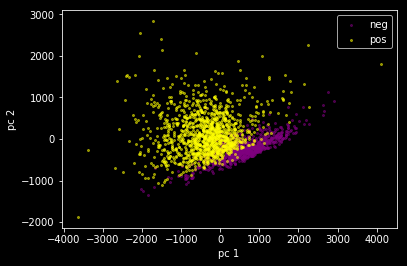

In [248]:
fig, ax = plt.subplots()
#X_new = X_new[np.where(df.y_consec_sig == False)[0],:]
neg = np.where(df[outcome_def] == False)[0]
pos = np.where(df[outcome_def] == True)[0]
ax.scatter(X_new[neg,0], X_new[neg,1], c='purple', label='neg', alpha=.5, s=4)
ax.scatter(X_new[pos,0], X_new[pos,1], c='yellow', label='pos', alpha=.5, s=4)
ax.legend()
ax.set_xlabel("pc 1")
ax.set_ylabel("pc 2")
plt.show()

In [208]:
tsne = TSNE(n_components=2, perplexity=30)
df_X = (df_X - df_X.mean()) / df_X.std()
X_new = tsne.fit_transform(df_X)

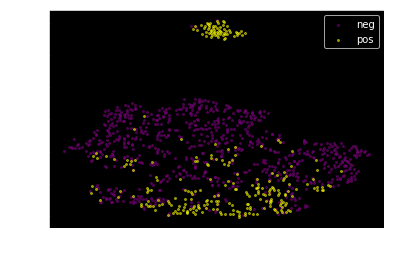

In [211]:
fig, ax = plt.subplots()
#X_new = X_new[np.where(df.y_consec_sig == False)[0],:]
neg = np.where(df_no_consec[outcome_def] == False)[0]
pos = np.where(df_no_consec[outcome_def] == True)[0]
ax.scatter(X_new[neg,0], X_new[neg,1], c='purple', label='neg', alpha=.5, s=4)
ax.scatter(X_new[pos,0], X_new[pos,1], c='yellow', label='pos', alpha=.5, s=4)
ax.legend()
ax.set_xlabel("dim 1")
ax.set_ylabel("dim 2")
plt.show()

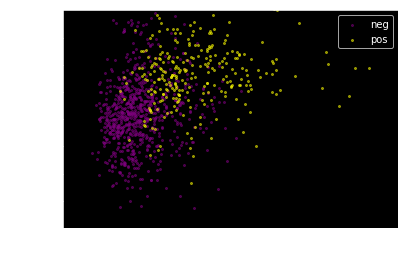

In [202]:
fig, ax = plt.subplots()
neg = np.where(df_no_consec[outcome_def] == False)[0]
pos = np.where(df_no_consec[outcome_def] == True)[0]
ax.scatter(df_no_consec['Y_max'].values[neg], df_no_consec['X_max_diff'].values[neg], c='purple', label='neg', alpha=.5, s=4)
ax.scatter(df_no_consec['Y_max'].values[pos], df_no_consec['X_max_diff'].values[pos], c='yellow', label='pos', alpha=.5, s=4)
ax.legend()
ax.set_ylim((-2000, 2000))
ax.set_xlim((0, 2000))
ax.set_xlabel("Y_max")
ax.set_ylabel("X_max_diff")
plt.show()

In [212]:
def extract_X_mat(df):
    p1 = max(df['X_peak_idx'].values)
    p2 = max(df['lifetime'].values - df['X_peak_idx'].values)
    n = df.shape[0]
    X_mat = np.zeros((n, p1 + p2)).astype(np.float32)
    X = df['X'].values
    for i in range(n):
        x = X[i]
        start = (p1 - df['X_peak_idx'].values[i])
        end = start + df['lifetime'].values[i]
        X_mat[i, start:end] = x
    X_mat = np.nan_to_num(X_mat)
    #X_mat -= np.min(X_mat)
    #X_mat /= np.std(X_mat)
    return X_mat

def extract_Y_mat(df):
    p1 = max(df['Y_peak_idx'].values)
    p2 = max(df['lifetime'].values - df['Y_peak_idx'].values)
    n = df.shape[0]
    Y_mat = np.zeros((n, p1 + p2)).astype(np.float32)
    Y = df['Y'].values
    for i in range(n):
        y = Y[i]
        start = (p1 - df['Y_peak_idx'].values[i])
        end = start + df['lifetime'].values[i]
        Y_mat[i, start:end] = y
    Y_mat = np.nan_to_num(Y_mat)
    #X_mat -= np.min(X_mat)
    #X_mat /= np.std(X_mat)
    return Y_mat

In [241]:
df_no_consec = df[df.y_consec_sig == False]
df_Y_mat = extract_Y_mat(df_no_consec)
df_X_mat = extract_X_mat(df_no_consec)
df_mat = np.concatenate((df_X_mat, df_Y_mat), axis=1)

In [242]:
from sklearn.decomposition import PCA, KernelPCA
pca = PCA(n_components=50)
df_mat_pca = pca.fit_transform(df_mat)

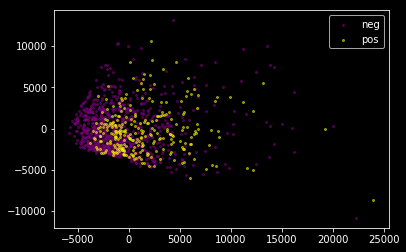

In [225]:
fig, ax = plt.subplots()
#X_new = X_new[np.where(df.y_consec_sig == False)[0],:]
neg = np.where(df_no_consec[outcome_def] == False)[0]
pos = np.where(df_no_consec[outcome_def] == True)[0]
ax.scatter(df_mat_pca[neg,0], df_mat_pca[neg,1], c='purple', label='neg', alpha=.5, s=4)
ax.scatter(df_mat_pca[pos,0], df_mat_pca[pos,1], c='yellow', label='pos', alpha=.5, s=4)
ax.legend()
plt.show()

In [238]:
df_mat_pca.shape

(1053, 10)

In [239]:
tsne = TSNE(n_components=2, perplexity=30)
df_mat_p = (df_mat - df_mat.mean()) / df_mat.std()
Y_new = tsne.fit_transform(df_mat_pca)

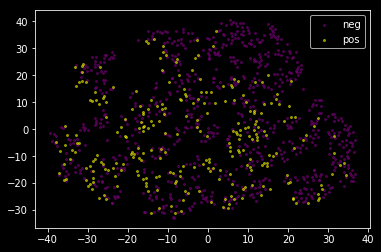

In [240]:
fig, ax = plt.subplots()
#X_new = X_new[np.where(df.y_consec_sig == False)[0],:]
neg = np.where(df_no_consec[outcome_def] == False)[0]
pos = np.where(df_no_consec[outcome_def] == True)[0]
ax.scatter(Y_new[neg,0], Y_new[neg,1], c='purple', label='neg', alpha=.5, s=4)
ax.scatter(Y_new[pos,0], Y_new[pos,1], c='yellow', label='pos', alpha=.5, s=4)
ax.legend()
plt.show()